In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

# 13.1 Visualising Event Data

In [3]:
from pathlib import Path

dataset_download_location: Path = Path('shapes_rotation.zip')
dataset_location = Path('data').joinpath(dataset_download_location.stem)

if not dataset_download_location.exists():
    !wget https://rpg.ifi.uzh.ch/datasets/davis/shapes_rotation.zip -O shapes_rotation.zip

In [4]:
from zipfile import ZipFile

if not Path('data').exists():
    with ZipFile(dataset_download_location, 'r') as zip_ref:
        zip_ref.extractall(dataset_location)

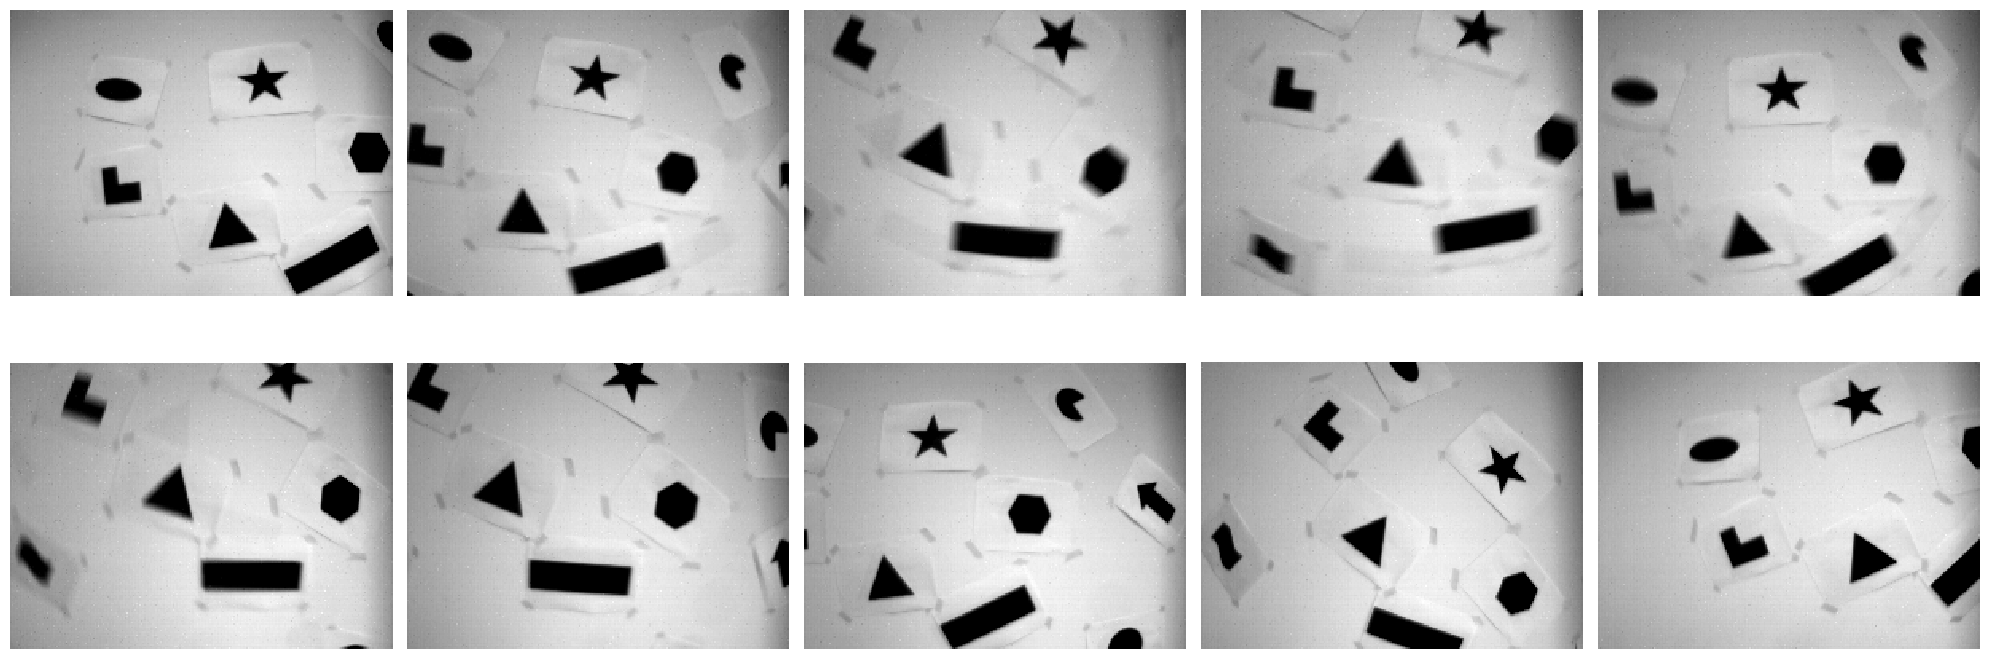

In [5]:
from random import sample

images_dir = dataset_location.joinpath('images')

images = sorted(images_dir.glob('*.png'))
sample_images = sample(images, 10)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for ax, image_path in zip(axes.flat, sample_images):
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

fig.tight_layout()

In [6]:
from typing import Tuple, List, TypeAlias

events_dir = dataset_location.joinpath('events.txt')

Coordinates: TypeAlias = Tuple[int, int]
Event: TypeAlias = Tuple[float, Coordinates, bool]

def create_event_list(data_dir: Path) -> List[Event]:
    with open(data_dir, 'r') as f:
        events = f.readlines()

    event_list: List[Event] = []
    for event in events:
        first, second, third, fourth = event.strip().split(' ')
        
        if float(first) >= 1.:
            break
            
        event_list.append((float(first), (int(second), int(third)), bool(int(fourth))))

    return event_list

event_data = create_event_list(events_dir)

In [7]:
print(f'Number of events: {len(event_data)}')

Number of events: 72045


In [8]:
print(f'First and last timestamp: {event_data[0][0], event_data[-1][0]}')

First and last timestamp: (0.0, 0.999996)


In [9]:
print(f'Maximum values for x and y coordinates: {max(event_data, key=lambda e: e[1][0])[1], max(event_data, key=lambda e: e[1][1])[1]}')

print(f'Minimum values for x and y coordinates: {min(event_data, key=lambda e: e[1][0])[1], min(event_data, key=lambda e: e[1][1])[1]}')

Maximum values for x and y coordinates: ((239, 157), (239, 179))
Minimum values for x and y coordinates: ((4, 87), (194, 1))


In [10]:
print(f'Number of pixels of negative and positive polarity: {sum([1 for event in event_data if not event[2]]), sum([1 for event in event_data if event[2]])}')

Number of pixels of negative and positive polarity: (41009, 31036)


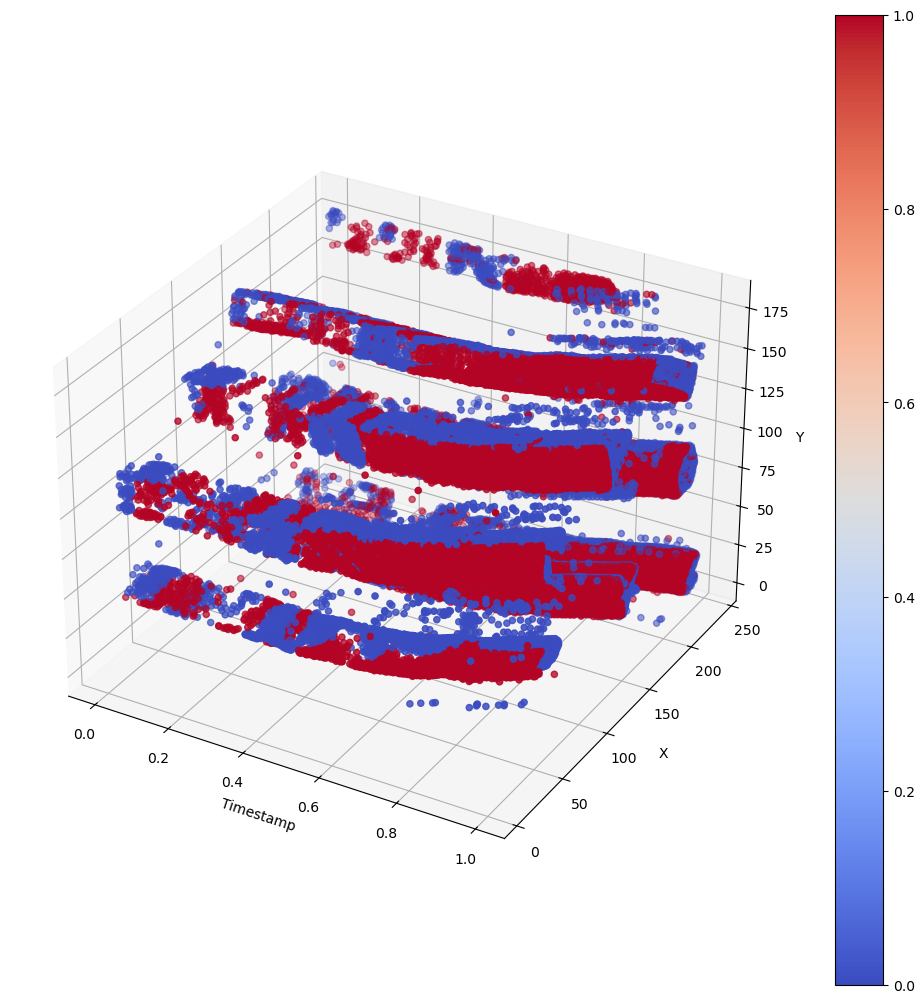

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, t, p = zip(*[(event[1][0], event[1][1], event[0], event[2]) for event in event_data])

sc = ax.scatter(t, x, y, c=p, cmap='coolwarm')
ax.set_xlabel('Timestamp')
ax.set_ylabel('X')
ax.set_zlabel('Y')

fig.tight_layout()
fig.colorbar(sc)

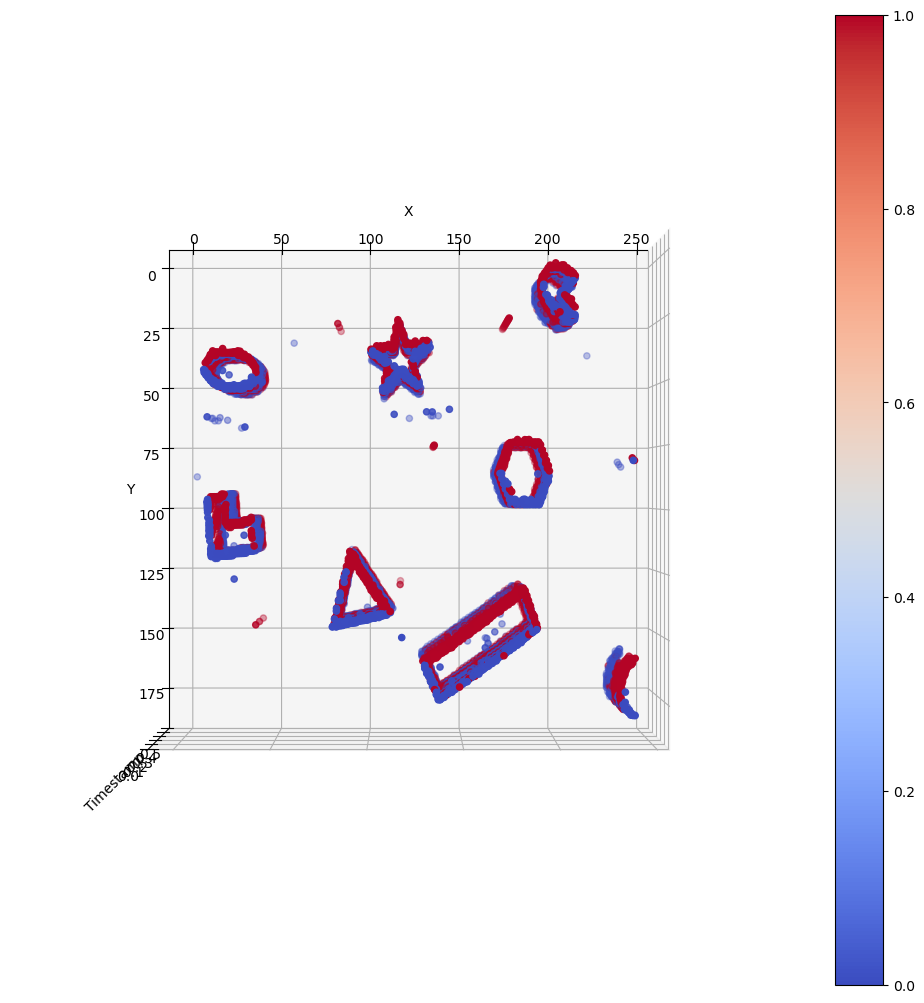

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, t, p = zip(*[(event[1][0], event[1][1], event[0], event[2]) for event in event_data[:8000]])

sc = ax.scatter(x, y, t, c=p, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Timestamp')
ax.view_init(elev=-90, azim=-90)

fig.tight_layout()
fig.colorbar(sc)

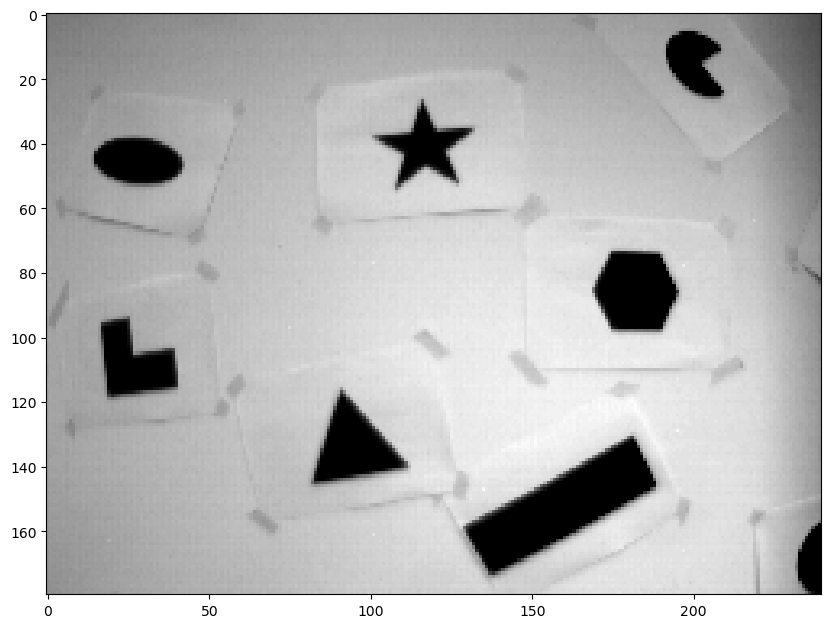

In [13]:
plt.imshow(cv2.imread(str(images[0]), cv2.IMREAD_GRAYSCALE), cmap='gray')

In [14]:
def find_timestamp_index(events: List[Event], timestamp: float) -> int:
    low, high = 0, len(events) - 1

    while low <= high:
        mid = (high + low) // 2

        if events[mid][0] == timestamp:
            return mid
        elif events[mid][0] < timestamp:
            low = mid + 1
        else:
            high = mid - 1

    return low

timestamp_index = find_timestamp_index(event_data, 0.5)

In [15]:
print(f'Index of timestamp 0.5: {timestamp_index}')

Index of timestamp 0.5: 9058


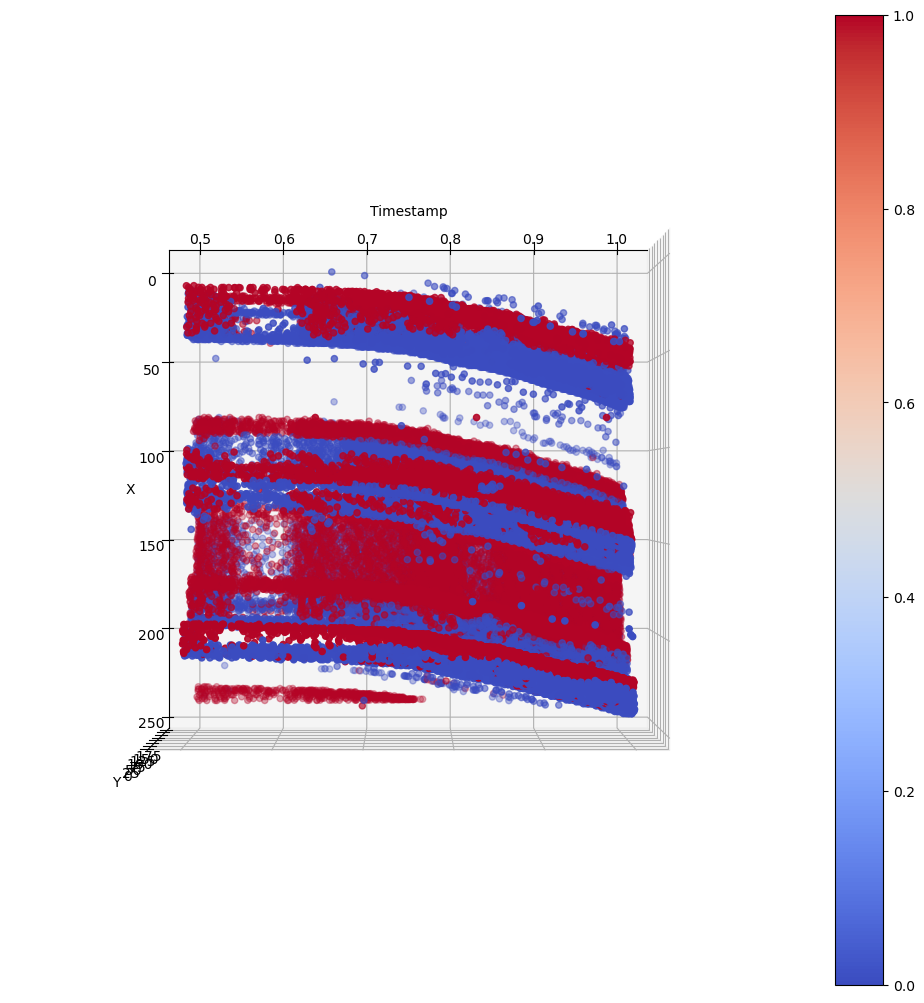

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, t, p = zip(*[(event[1][0], event[1][1], event[0], event[2]) for event in event_data[timestamp_index:]])

sc = ax.scatter(t, x, y, c=p, cmap='coolwarm')
ax.set_xlabel('Timestamp')
ax.set_ylabel('X')
ax.set_zlabel('Y')
ax.view_init(elev=-90, azim=-90)

fig.tight_layout()
fig.colorbar(sc)

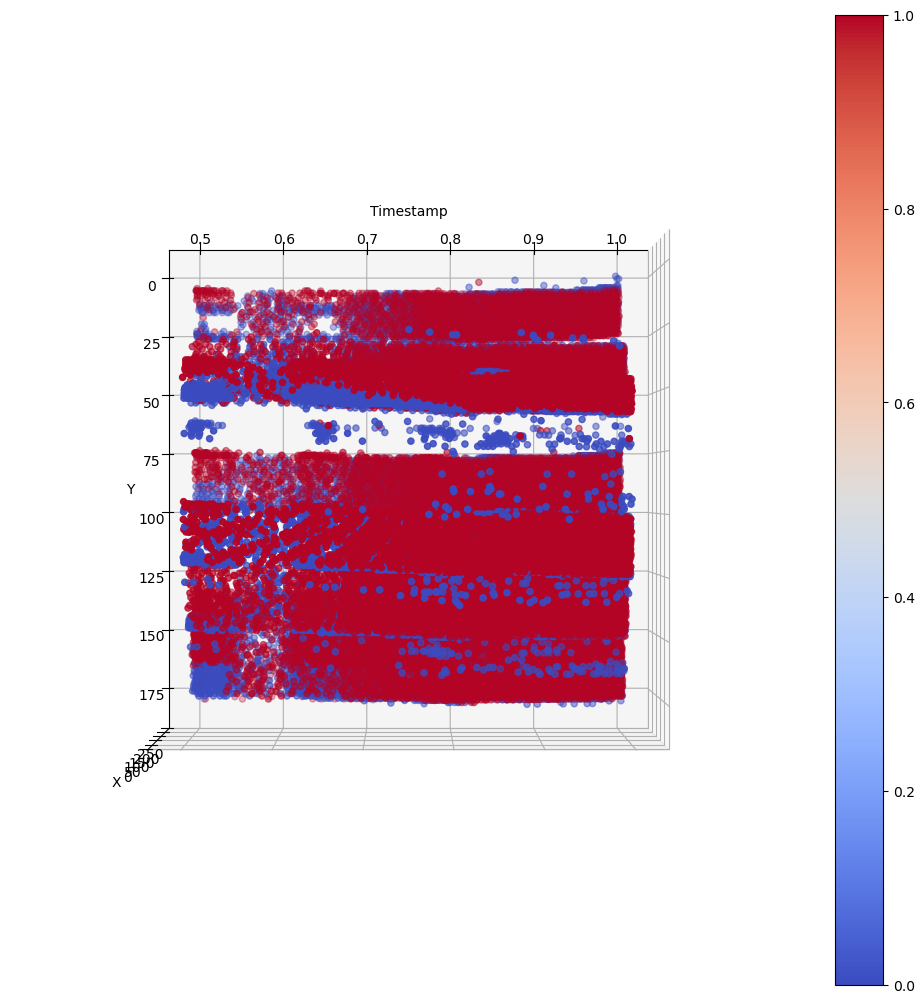

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(t, y, x, c=p, cmap='coolwarm')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Y')
ax.set_zlabel('X')
ax.view_init(elev=-90, azim=-90)

fig.tight_layout()
fig.colorbar(sc)

In [18]:
AdvancedEvent: TypeAlias = Tuple[float, Coordinates, int]

def create_advanced_event_list(data_dir: Path) -> List[AdvancedEvent]:
    with open(data_dir, 'r') as f:
        events = f.readlines()

    event_list: List[AdvancedEvent] = []
    for event in events:
        first, second, third, fourth = event.strip().split(' ')

        if float(first) < 1.:
            continue
        
        if float(first) > 2.:
            break

        event_list.append((float(first), (int(second), int(third)), 1 if bool(int(fourth)) else -1))

    return event_list

event_data = create_advanced_event_list(events_dir)

In [19]:
def event_frame(events: List[AdvancedEvent], shape: Tuple[int, ...]) -> np.ndarray:
    matrix = np.full(shape, 127, dtype=np.int8)
    
    for _, (x_e, y_e), polarity in events:
        if polarity == 1:
            matrix[x_e, y_e] = np.iinfo(np.int8).max
        else:
            matrix[x_e, y_e] = np.iinfo(np.int8).min
    
    return matrix

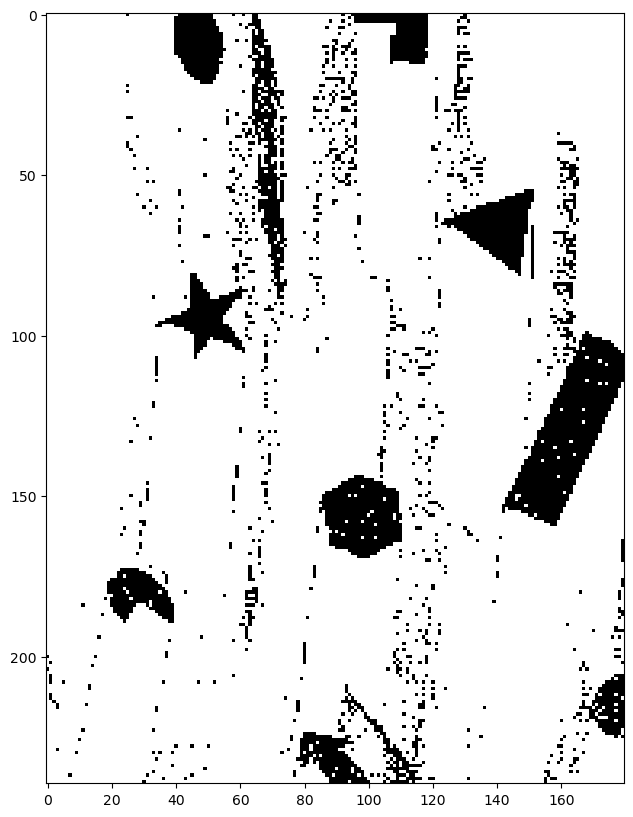

In [20]:
plt.imshow(event_frame(event_data, (240, 180)), cmap='gray')

In [21]:
def play_video(tau: float, events: List[AdvancedEvent], shape: Tuple[int, ...]) -> None:
    temporary_list: List[AdvancedEvent] = []
    
    for event in events:
        temporary_list.append(event)
        
        if temporary_list[-1][0] - temporary_list[0][0] > tau:
            processed_image = event_frame(temporary_list, shape)
            
            cv2.imshow('Video', processed_image)
            
            if cv2.waitKey(50) & 0xFF == ord('q'):
                break
                   
            temporary_list.clear()        
            
    cv2.destroyAllWindows()

In [22]:
play_video(0.01, event_data, (240, 180))

In [23]:
play_video(0.1, event_data, (240, 180))

In [24]:
play_video(0.001, event_data, (240, 180))